In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import sys
path = os.getcwd()
f_path, _ = os.path.split(path)
sys.path.insert(0, f_path)
print(f_path)
from src.featurizers import * # import DateTimeFeaturizer
from src.feature_ensemblers import *
import lightgbm as lgb
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import numpy as np
from dmatrix2np import dmatrix_to_numpy
from sklearn.datasets import load_svmlight_file
import xgboost as xgb
import math
from catboost import CatBoostRegressor,CatBoostClassifier,Pool
import re

/Users/david2020/Desktop/AISI/AISI/supplementary_material/Code


/Users/david2020/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/david2020/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/david2020/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/david2020/opt/anaconda3/lib/python3.8/site-pa

In [2]:
%matplotlib notebook

In [3]:
def get_acc(ypred, ytrue):
    acc_day=[]
    for jth in range(len(ytrue)//96):
        acc_day.append(accuracy(ypred[jth*96:(jth+1)*96], ytrue[jth*96:(jth+1)*96], jth))
    return np.nanmean(acc_day)
def accuracy(ypred, ytrue, jth): 
    if ytrue.size != ypred.size:
        raise ValueError('Incompatible size!')
    
    elif ytrue.size == 0:
        return 0
    
    else:
        acc = 1 - np.sqrt(np.nanmean(((ytrue - ypred) / ytrue) ** 2))
        print('Day{}, acc={}'.format(jth, acc))
        return acc

def my_closure11(vector):
    def T_Loss(y,data):    
        t = data.get_label()        
        coff_T=vector['accumulate_temperature'].apply(lambda x:1*2/(1+1*math.exp(-x+30+273.15)) if x>30+273.15 else 1)
        grad=[i*j for i, j in zip(1/2*(y-t), coff_T)] 
        hess=1/2*coff_T
        return grad,hess
    return T_Loss

def my_closure12(vector):
    def Terror(y,data):
        t = data.get_label()
        coff_T=vector['accumulate_temperature'].apply(lambda x:1*2/(1+1*math.exp(-x+30+273.15)) if x>30+273.15 else 1)
        loss=[i*j for i, j in zip((y-t)**2, coff_T)]     
        return "T_loss",np.mean(loss)
    return Terror

def my_closure21(y, data):
#     def T_Loss(y,data):    
    d = data.get_data()        
    t = data.get_label()
#     pdb.set_trace()
    coff_T= d['accumulate_temperature'].apply(lambda x:1*2/(1+1*math.exp(-x+30+273.15)) if x>30+273.15 else 1)
    grad=[i*j for i, j in zip(1/2*(y-t), coff_T)] 
    hess=1/2*coff_T
    return grad,hess
#     return T_Loss
def my_closure22(y, data):
#     def Terror(y,data):
    d = data.get_data()
    t = data.get_label()
    w = data.get_weight()
    coff_T= d['accumulate_temperature'].apply(lambda x:1*2/(1+1*math.exp(-x+30+273.15)) if x>30+273.15 else 1)
    loss=[i*j for i, j in zip((y-t)**2, coff_T)]     
    return "T_loss",np.mean(loss), False
#     return Terror

In [4]:
def extract_split_info(source_code,all_feature_map_dict):
    feature_map_dict = {}
    for item in source_code.split('\n'):
        if item.startswith('\t0'):
            if 'label="' in item: 
                item_in = re.search('label=".+?"',item).group(0).replace('"','').replace(' ','')
                feature_map_name, split_v = item_in.split(',')
                feature_map_name = feature_map_name.replace('label=','')
                feature_map_dict[split_v] = {}
            elif item.startswith('\t0 -> 1'):
                item_in = re.search('label=.+?]',item).group(0).replace(']','').replace('label=','')
                left = item_in
                feature_map_dict[split_v][left]=0
            elif item.startswith('\t0 -> 2'):
                item_in = re.search('label=.+?]',item).group(0).replace(']','').replace('label=','')
                right = item_in
                feature_map_dict[split_v][right]=0
        elif item.startswith('\t1'):
            if 'label="' in item:
                aa,item_in = item.split('val = ')
                left_value = float(item_in)
        elif item.startswith('\t2'):
            if 'label="' in item: 
                aa,item_in = item.split('val = ')
                right_value = float(item_in)
    feature_map_dict[split_v][left] = left_value
    feature_map_dict[split_v][right] = right_value
    if feature_map_name not in all_feature_map_dict.keys():
        all_feature_map_dict[feature_map_name] = {}
    all_feature_map_dict[feature_map_name].update(feature_map_dict)
def extract_value(string):
    return(float(string.replace('value>','')))
# def extract_value(string):
#     return(float(string.replace('value>','')))
def generate_basis(all_feature_map_dict,train_df):
    result_dict = {}
    for key,value in all_feature_map_dict.items():
        result_dict[key] = {}
        splits = train_df[key].sort_values().values
        f_values = np.zeros(splits.shape)
        for key_1, value_1 in value.items():
            spl = float(key_1.replace('value>',''))
            f_values[splits>spl] += value_1['Yes']
            f_values[splits<=spl] += value_1['No']
        result_dict[key]['index'] = splits
        result_dict[key]['value'] = f_values
    return result_dict
def extract_basis_from_catboost(model,pool,train_df):
    all_feature_map_dict = {}
    for ii in range(model.get_param('iterations')):
        source_code = model.plot_tree(ii, pool=pool).source
        extract_split_info(source_code,all_feature_map_dict)
    result_dict = generate_basis(all_feature_map_dict,train_df)
    return result_dict

<IPython.core.display.Javascript object>


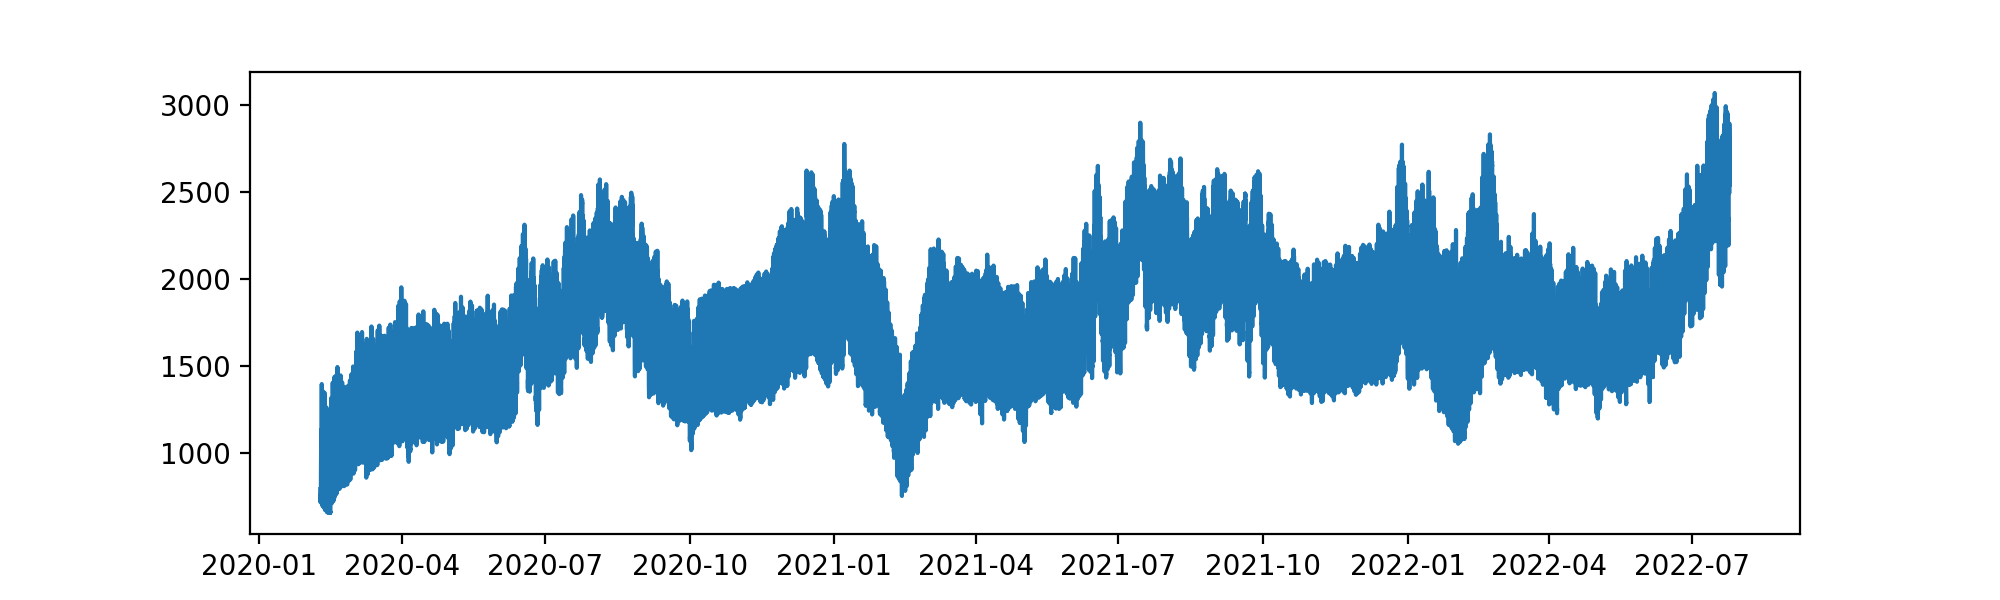

In [5]:
df = pd.read_csv('../../../data/huazhong/jiangxi_20200209_20220725.csv', parse_dates=['Unnamed: 0'])
df = df.set_index('Unnamed: 0')
#print(df)
%matplotlib notebook
plt.figure(figsize=(10,3))
y = df['load']
plt.plot(y)

In [6]:
datefea = DateTimeFeaturizer(feature_col=['index_15min', 'year', 'day', 'day_of_year',
                                                                          'day_of_year_sin', 'day_of_year_cos',
                                                                          'month', 'day_of_month_sin',
                                                                          'day_of_month_cos',
                                                                          'day_of_week', 'is_weekend',
                                                                          'day_of_week_sin',
                                                                          'day_of_week_cos', 'hour',
                                                                          'is_special_workday',
                                                                          'is_special_holiday'])
difffea = DifferenceFeaturizer(offsets=192,
                               feature_col=['Surface_pressure',
                                   'Surface_sensible_heat_flux',
                                   'Total_cloud_cover',
                                   'Surface_net_solar_radiation',
                                   'Total_precipitation', 'Skin_temperature'])

difffea2 = DifferenceFeaturizer(offsets=192,
                               feature_col=['2_metre_temperature',
                                   'accumulate_temperature',
                                   'Skin_temperature'])

rfea1 = RollingStatsFeaturizer(offsets=192,
                               feature_col=['load'], wins=[1, 7],
                               quantiles=[0.25, 0.75])
rfea2 = RollingStatsFeaturizer(offsets=192,
                               wins=[7, 14],
                               quantiles=[0.25, 0.75],
                               feature_col=['load'],
                               is_interval=True)
rfea3 = RollingStatsFeaturizer(offsets=192,
                               wins=[1, 7],
                               quantiles=[0.25, 0.75],
                               feature_col=['2_metre_temperature',
                                   'accumulate_temperature',
                                   'Skin_temperature'],
                               is_interval=True)

feature_en = FeatureEnsembler(featurizers=[datefea, difffea, rfea1, rfea2])

feature_en2 = FeatureEnsembler(featurizers=[datefea, difffea2, rfea1])

## 分解

<IPython.core.display.Javascript object>


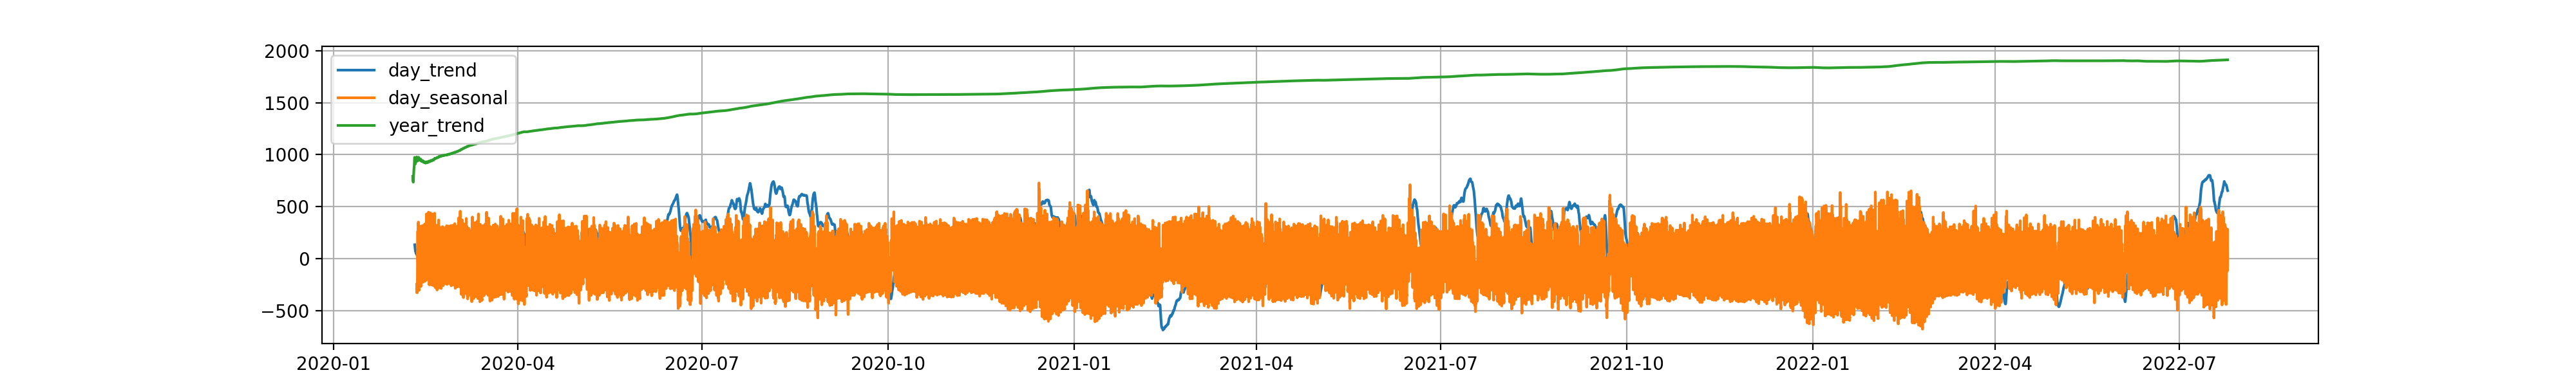

In [7]:
dfyt = df.copy()

# 年趋势
dfyt['load'] = dfyt['load'].rolling(96*30*12, min_periods=1).mean()
res = (df['load'] - dfyt['load']).to_frame()

# 日趋势
dft = df.copy()
dft['load'] = (res['load'].rolling(96).mean()).to_frame()

# 日周期项
dfs = df.copy()
dfs['load'] = (res['load'] - dft['load'].rolling(96).mean()).to_frame()

# 作图看一下
plt.figure(figsize=(20,3))
plt.plot(dft['load'])
plt.plot(dfs['load'])
plt.plot(dfyt['load'])
plt.legend(['day_trend', 'day_seasonal', 'year_trend'])
plt.grid()

In [8]:
def engi_pred(feature_en, df, flag=True, diff=False, model='lgb', xslice='all'):
    if flag:
        dffea = feature_en.transform(df)
        print(dffea.columns)
    else:
        dffea = df
        print(df.columns)
    dffea2 = dffea.copy()
    if diff:
        Y_ori = dffea['load'].copy()
        dffea2 = dffea.copy()
        dffea2['load'] = (dffea2['load'] - dffea2['load'].shift(192)) #.iloc[192:]
    Y = dffea2.pop('load')
    X = dffea2
    
    split1 = datetime(2022,5,1,0,15)
    split2 = datetime(2022,6,1,0,15)
    
    if xslice == 'summer':
        slice0 = slice(datetime(2020,6,1), datetime(2020,9,1))
        slice1 = slice(datetime(2021,6,1), datetime(2021,9,1))
        slice2 = slice(datetime(2022,5,1), datetime(2022,6,1))
        X_train = pd.concat([X[slice0], X[slice1], X[slice2]])
        Y_train = pd.concat([Y[slice0], Y[slice1], Y[slice2]])
    elif xslice == 'all':
        split0 = datetime(2020,7,1,0,15)
        X_train = X[split0:split1]
        Y_train = Y[split0:split1]  
    
    X_valid = X[split1: split2]
    X_test = X[split2:]
    
    Y_valid = Y[split1: split2]
    Y_test = Y[split2:]
    
    X_test2 = X[datetime(2021,6,1,0,15): datetime(2021,7,25,0,15)]
    Y_test2 = Y[datetime(2021,6,1,0,15): datetime(2021,7,25,0,15)]
    
    train_params = {
                    'params': {
                        'num_threads': 12,
                        'learning_rate': 0.02,
                        'boosting_type': 'gbdt',
                        'objective': 'regression',
                        'metric': 'mae',
                        'num_leaves': 45,
                        'min_data_in_leaf': 60,
                        'feature_fraction': 0.9,
                        'bagging_fraction': 0.9,
                        'bagging_freq': 1,
                        'seed': 16,
                        'verbosity': -1,
                        'max_bins': 300,
                        'num_iterations': 2000,
#                         'max_depth': 1
                    },
                    'callbacks': [
                        lgb.log_evaluation(500)
                    ],
                    'early_stopping_rounds': 2000
                }
    if model == 'lgb':
        train_params = {
                    'params': {
                        'num_threads': 12,
                        'learning_rate': 0.01,
                        'boosting_type': 'gbdt',
                        'objective': 'regression',
                        'metric': 'mse',
                        'num_leaves': 45,
                        'min_data_in_leaf': 100,
                        'feature_fraction': 0.9,
                        'bagging_fraction': 0.9,
                        'bagging_freq': 1,
                        'seed': 16,
                        'verbosity': -1,
                        'max_bins': 300,
                        'num_iterations': 8000,
#                         'max_depth': 1
                    },
                    'callbacks': [
                        lgb.log_evaluation(500)
                    ],
                    'early_stopping_rounds': 2000
                }
        print('lgb')
        train_set = lgb.Dataset(X_train, Y_train) #, **self.param['dataset_params'])
        valid_sets = [train_set, lgb.Dataset(X_valid, Y_valid)]
#         model = lgb.train(train_set=train_set, valid_sets=valid_sets, **train_params)
        model = lgb.train(train_set=train_set, valid_sets=train_set, **train_params)
        if diff:
            Y_pred = pd.DataFrame({'load': model.predict(X_test)}, 
                                  index=Y_test.index) + Y_ori.shift(192)[Y_test.index].to_frame()
            Y_pred2 = pd.DataFrame({'load': model.predict(X_test2)}, 
                                  index=Y_test2.index) + Y_ori.shift(192)[Y_test2.index].to_frame()
#             return Y_pred, Y_ori[Y_test.index], Y_pred2, Y_ori[Y_test2.index] #, pd.DataFrame({'load': model.predict(X_test)}, 
    #                               index=Y_test.index), Y_test
            Y_test = Y_ori[Y_test.index]
        else:
            Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
#             return Y_pred, Y_test #Y_ori #, pd.DataFrame({'load': model.predict(X_test)}, 
    #                               index=Y_test.index), Y_test
    elif model == 'linear':
        model = LinearRegression()
        model.fit(X_train, Y_train)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
        
    elif model == 'svr':
        model = SVR()
        model.fit(X_train, Y_train)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
        
    elif model == 'lgbloss':
        train_params = {
                    'params': {
                        'num_threads': 12,
                        'learning_rate': 0.1,
                        'boosting_type': 'gbdt',
                        'objective': 'regression',
                        'metric': 'mae',
                        'num_leaves': 2,
                        'min_data_in_leaf': 1,
                        'feature_fraction': 0.9,
                        'bagging_fraction': 0.9,
                        'bagging_freq': 1,
                        'seed': 16,
                        'verbosity': -1,
                        'max_bins': 300,
                        'num_iterations': 10000,
#                         'max_depth': 1
                    },
                    'callbacks': [
                        lgb.log_evaluation(500)
                    ],
                    'early_stopping_rounds': 2000
                }
        train_set = lgb.Dataset(X_train, Y_train, free_raw_data=False) #, **self.param['dataset_params'])
        valid_sets = [train_set, lgb.Dataset(X_valid, Y_valid, free_raw_data=False)]
        model = lgb.train(train_set=train_set, valid_sets=valid_sets, **train_params,
                         fobj=my_closure21,
                         feval=my_closure22)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
#         dtrain = xgb.DMatrix(X_train, label=Y_train)
#         dvalid=xgb.DMatrix(X_test)
#         model=xgb.train(xgm_params,dtrain=dtrain,num_boost_round=num_boost,
#                           obj=my_closure11(X_train),
#                           feval=my_closure12(X_train))
#         Y_pred = pd.DataFrame({'load': model.predict(dvalid)}, index=Y_test.index)
        
    elif model == 'gam':
        model = CatBoostRegressor(learning_rate=0.01, depth=1, verbose=5000, loss_function='RMSE',iterations=20000)
        fit_model = model.fit(X_train, Y_train)
        Y_pred = pd.DataFrame({'load': model.predict(X_test)}, index=Y_test.index)
        
        
    Y_pred_train = pd.DataFrame({'load': model.predict(X_train)}, index=Y_train.index)
    plt.figure(figsize=(30,3))
    plt.plot(Y_pred_train)
    plt.plot(Y_train)
    plt.plot(Y_test)
    plt.plot(Y_pred)
    plt.legend(['pred', 'true', 'true', 'pred'])
    return Y_pred, Y_test, model


# coff_T=vector['accumulate_temperature'].apply(lambda x:1*2/(1+1*math.exp(-x+30+273.15)) if x>30+273.15 else 1)
#         grad=[i*j for i, j in zip(1/2*(y-t), coff_T)] 
#         hess=1/2*coff_T

class GAM_Objective(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
#             der1 = (targets[index] - approxes[index]) / np.sqrt(abs(targets[index] - approxes[index])**2+1)
#             der2 = -1 / np.sqrt(abs(targets[index] - approxes[index])**2+1)
#             der1 = (targets[index] - approxes[index]) / (abs(targets[index] - approxes[index])+1)
#             der2 = -1 / (abs(targets[index] - approxes[index])+1)
#             coff_T = 

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
class GAM_Metric(object):
    def get_final_error(self, error, weight):
        return np.abs(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * (abs(approx[i] - target[i]))

        return error_sum, weight_sum

Index(['Unnamed_0', 'Surface_pressure', 'Surface_sensible_heat_flux',
       'Total_cloud_cover', '10_metre_U_wind_component',
       '10_metre_V_wind_component', '2_metre_temperature',
       '2_metre_dewpoint_temperature', 'Surface_solar_radiation_downwards',
       'Surface_net_solar_radiation', 'Surface_net_solar_radiation_clear_sky',
       'Total_precipitation', 'Skin_temperature', '100_metre_U_wind_component',
       '100_metre_V_wind_component', 'load', 'index_15min', 'year', 'day',
       'day_of_year', 'day_of_year_sin', 'day_of_year_cos', 'month',
       'day_of_month_sin', 'day_of_month_cos', 'day_of_week', 'is_weekend',
       'day_of_week_sin', 'day_of_week_cos', 'hour', 'is_special_workday',
       'is_special_holiday', 'Surface_pressure_diff_offset_192',
       'Surface_sensible_heat_flux_diff_offset_192',
       'Total_cloud_cover_diff_offset_192',
       'Surface_net_solar_radiation_diff_offset_192',
       'Total_precipitation_diff_offset_192',
       'Skin_temperatu

<IPython.core.display.Javascript object>


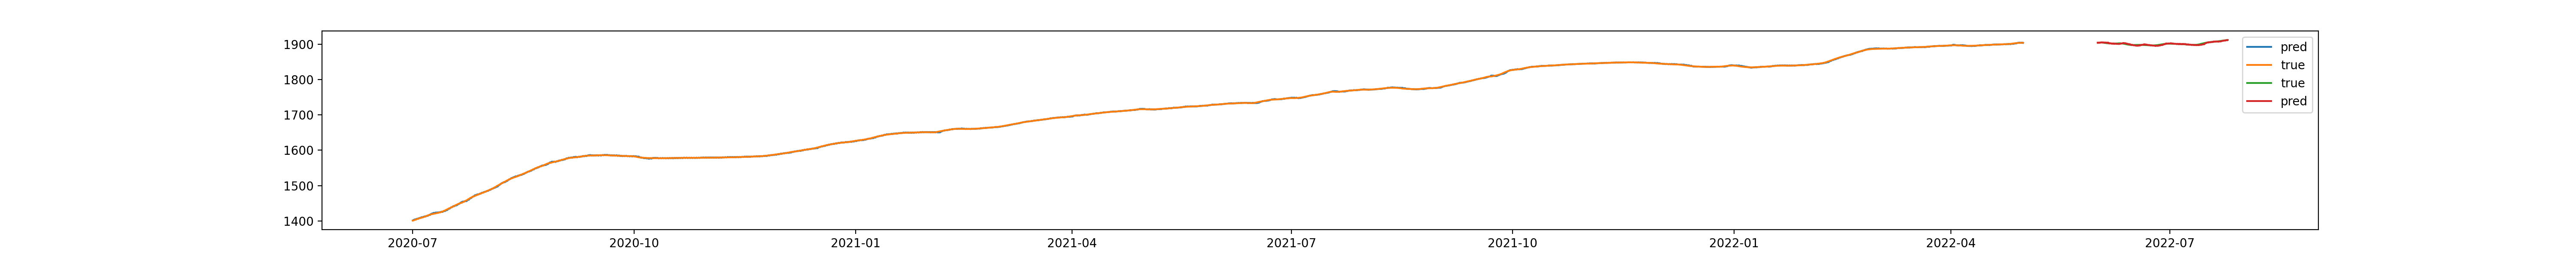

Index(['Skin_temperature', 'Total_precipitation',
       'Surface_solar_radiation_downwards', 'Total_cloud_cover',
       '100_metre_V_wind_component', '10_metre_V_wind_component',
       '10_metre_U_wind_component', '100_metre_U_wind_component',
       'Surface_pressure', '2_metre_dewpoint_temperature',
       '2_metre_temperature', 'Surface_net_solar_radiation',
       'Surface_sensible_heat_flux', 'Surface_net_solar_radiation_clear_sky',
       'load', 'accumulate_temperature', 'index_15min', 'year', 'day',
       'day_of_year', 'day_of_year_sin', 'day_of_year_cos', 'month',
       'day_of_month_sin', 'day_of_month_cos', 'day_of_week', 'is_weekend',
       'day_of_week_sin', 'day_of_week_cos', 'hour', 'is_special_workday',
       'is_special_holiday', '2_metre_temperature_diff_offset_192',
       'accumulate_temperature_diff_offset_192',
       'Skin_temperature_diff_offset_192', 'load_win_1_offset_192_mean',
       'load_win_1_offset_192_q025', 'load_win_1_offset_192_q075',
       

<IPython.core.display.Javascript object>


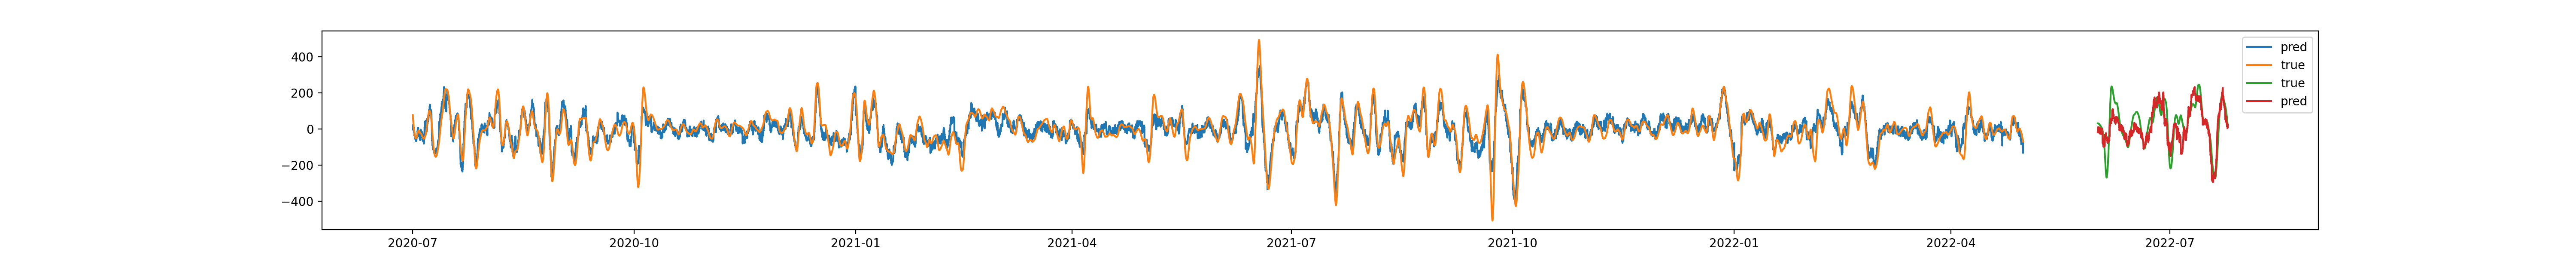

In [9]:
# 建立 累积温度 特征
dftt = dft[[
 'Skin_temperature',
 'Total_precipitation',
 'Surface_solar_radiation_downwards',
 'Total_cloud_cover',
 '100_metre_V_wind_component',
 '10_metre_V_wind_component',
 '10_metre_U_wind_component',
 '100_metre_U_wind_component',
 'Surface_pressure',
 '2_metre_dewpoint_temperature',
 '2_metre_temperature',
 'Surface_net_solar_radiation',
 'Surface_sensible_heat_flux',
 'Surface_net_solar_radiation_clear_sky','load']].copy()

# dftt['wind'] = np.sqrt(dft['10_metre_V_wind_component']**2 + dft['10_metre_U_wind_component']**2)

tt = 'Skin_temperature'

dftt['accumulate_temperature'] = 0.5 * dft[tt] + \
                                 0.3 * dft[tt].shift(96) + \
                                 0.15 * dft[tt].shift(192) + \
                                 0.1 * dft[tt].shift(288) + \
                                 0.05 * dft[tt].shift(384)
# dft['accumulate_temperature'] = 0.5 * dft[tt] + \
#                                  0.3 * dft[tt].shift(96) + \
#                                  0.15 * dft[tt].shift(192) + \
#                                  0.1 * dft[tt].shift(288) + \
#                                  0.05 * dft[tt].shift(384)

# 预测 年趋势，日趋势，日周期
Y_pred1, Y_test1,model = engi_pred(feature_en, dfyt, flag=True, diff=False, model='linear', xslice='all')
xslice = 'all'
Y_pred2, Y_test2,model = engi_pred(feature_en2, dftt.rolling(96).mean(), flag=True, 
                             diff=True, model='gam', xslice=xslice)

<IPython.core.display.Javascript object>


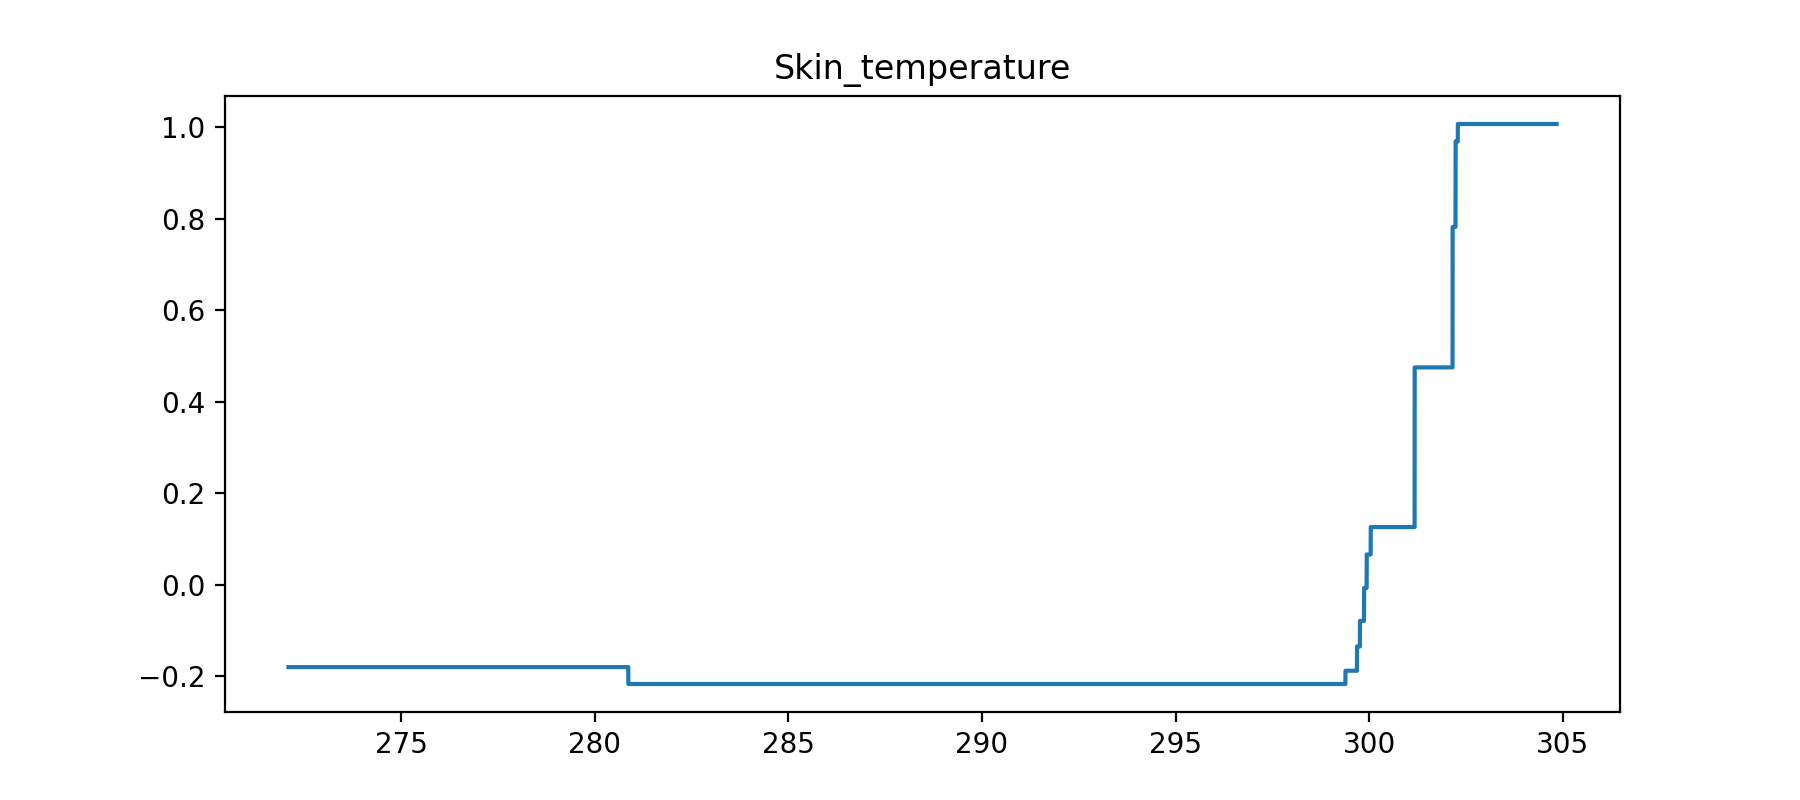

<IPython.core.display.Javascript object>


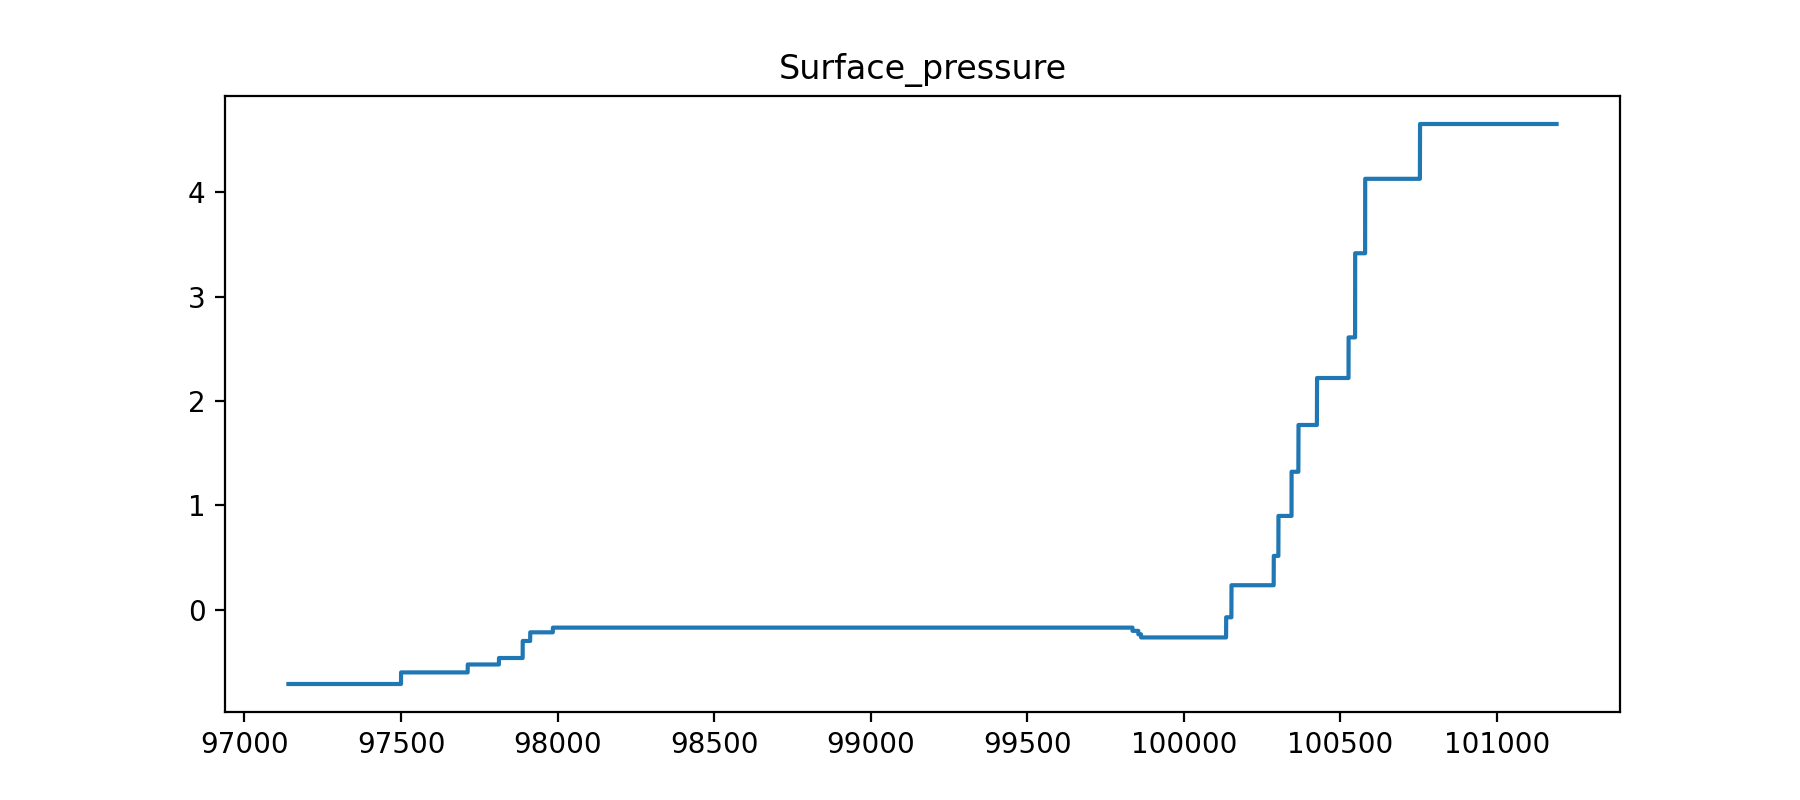

<IPython.core.display.Javascript object>


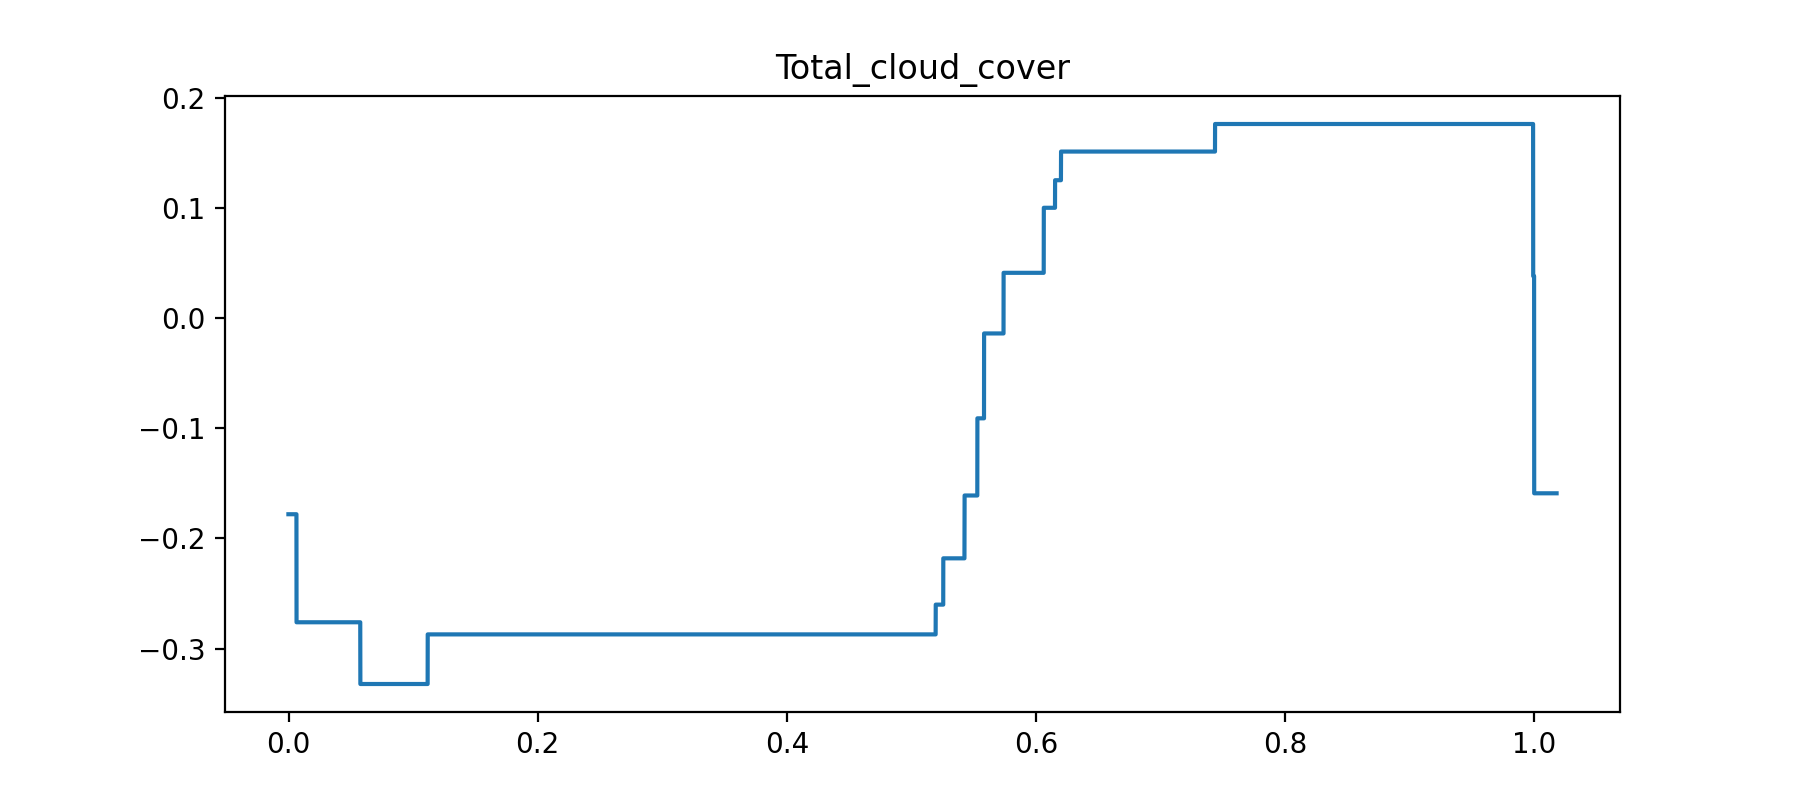

<IPython.core.display.Javascript object>


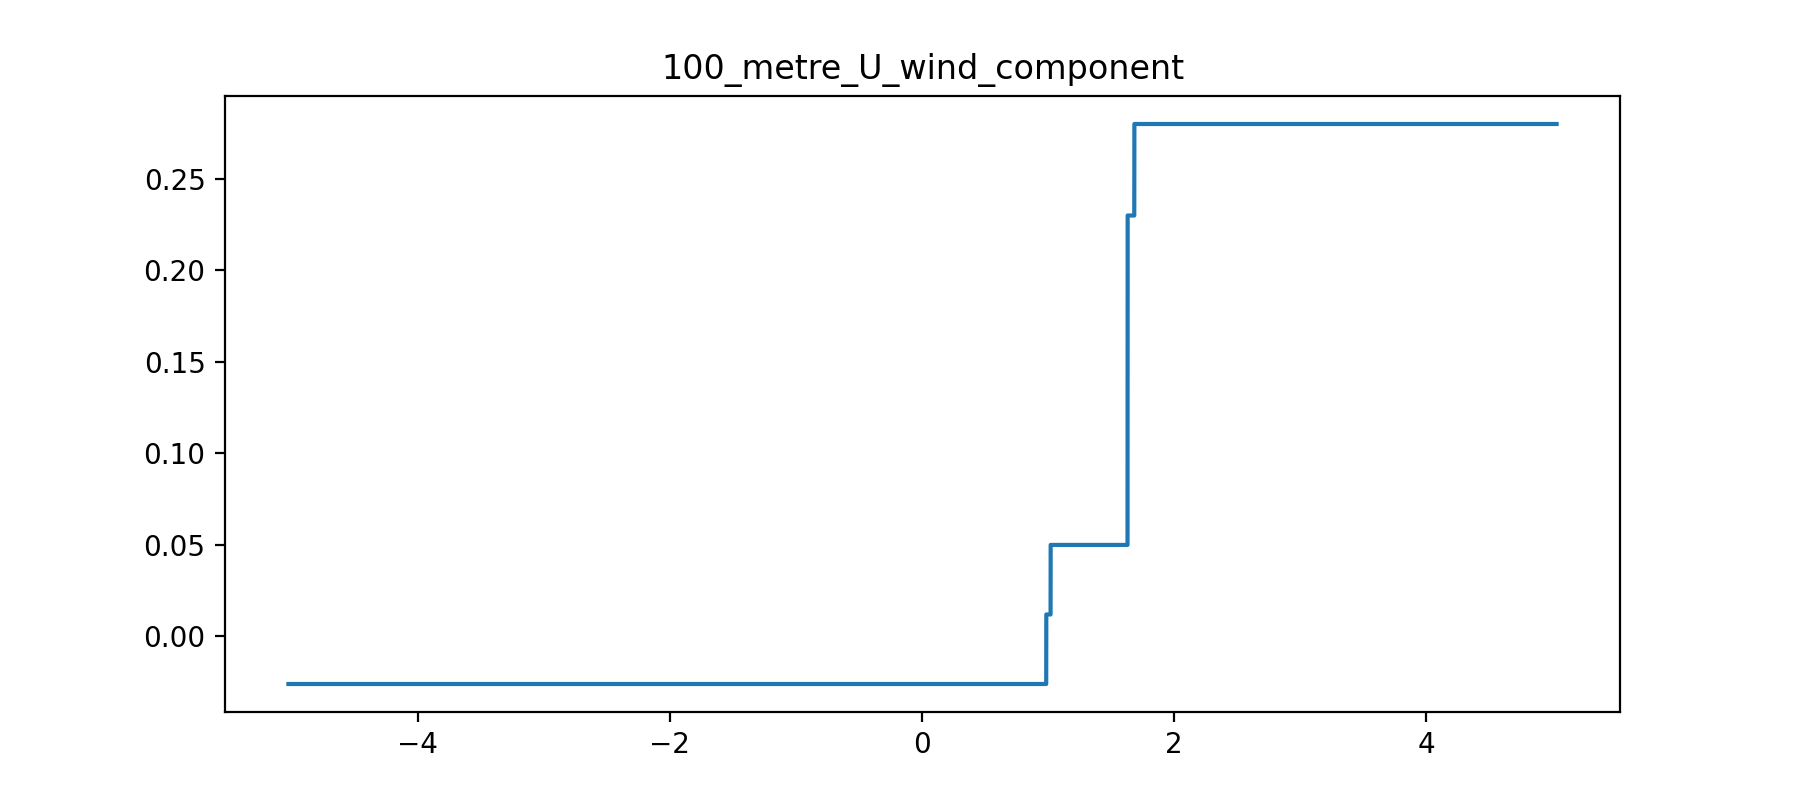

<IPython.core.display.Javascript object>


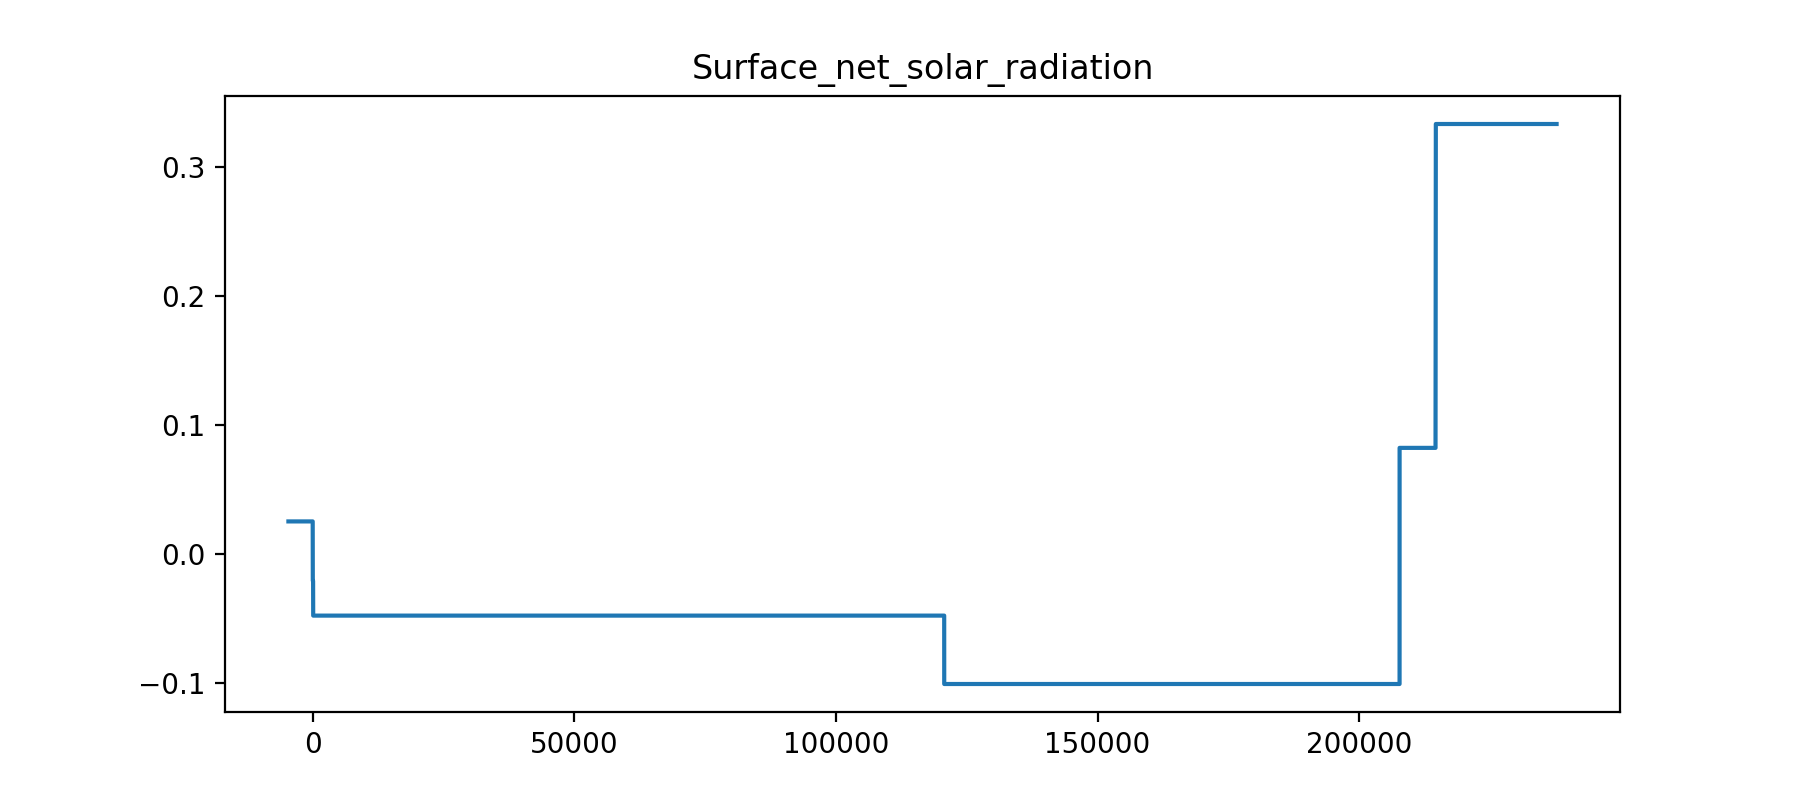

<IPython.core.display.Javascript object>


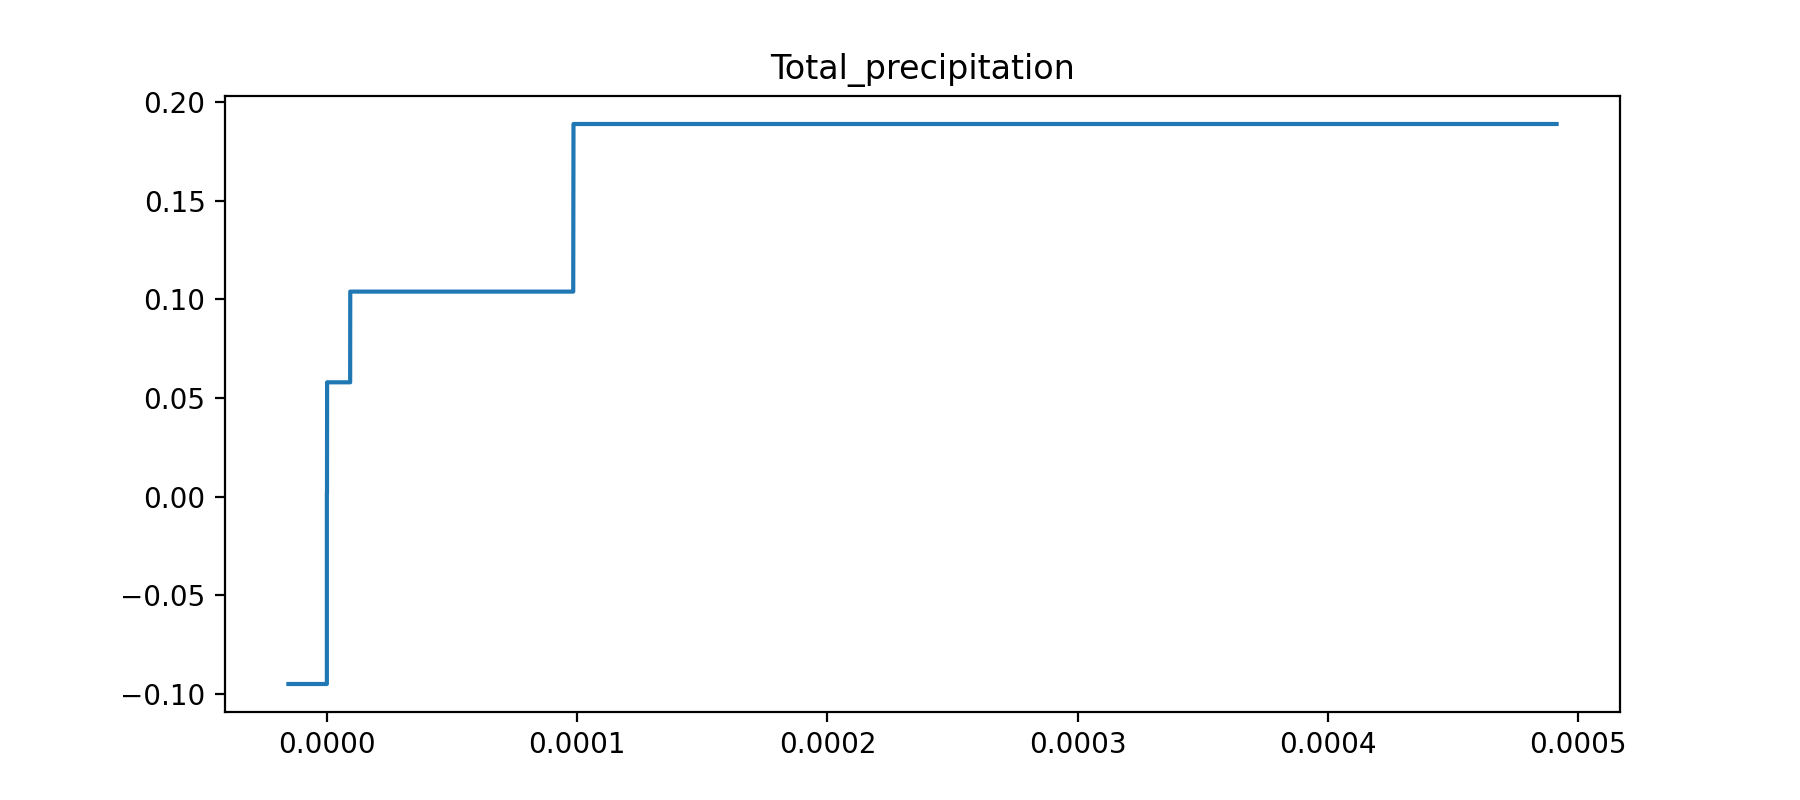

<IPython.core.display.Javascript object>


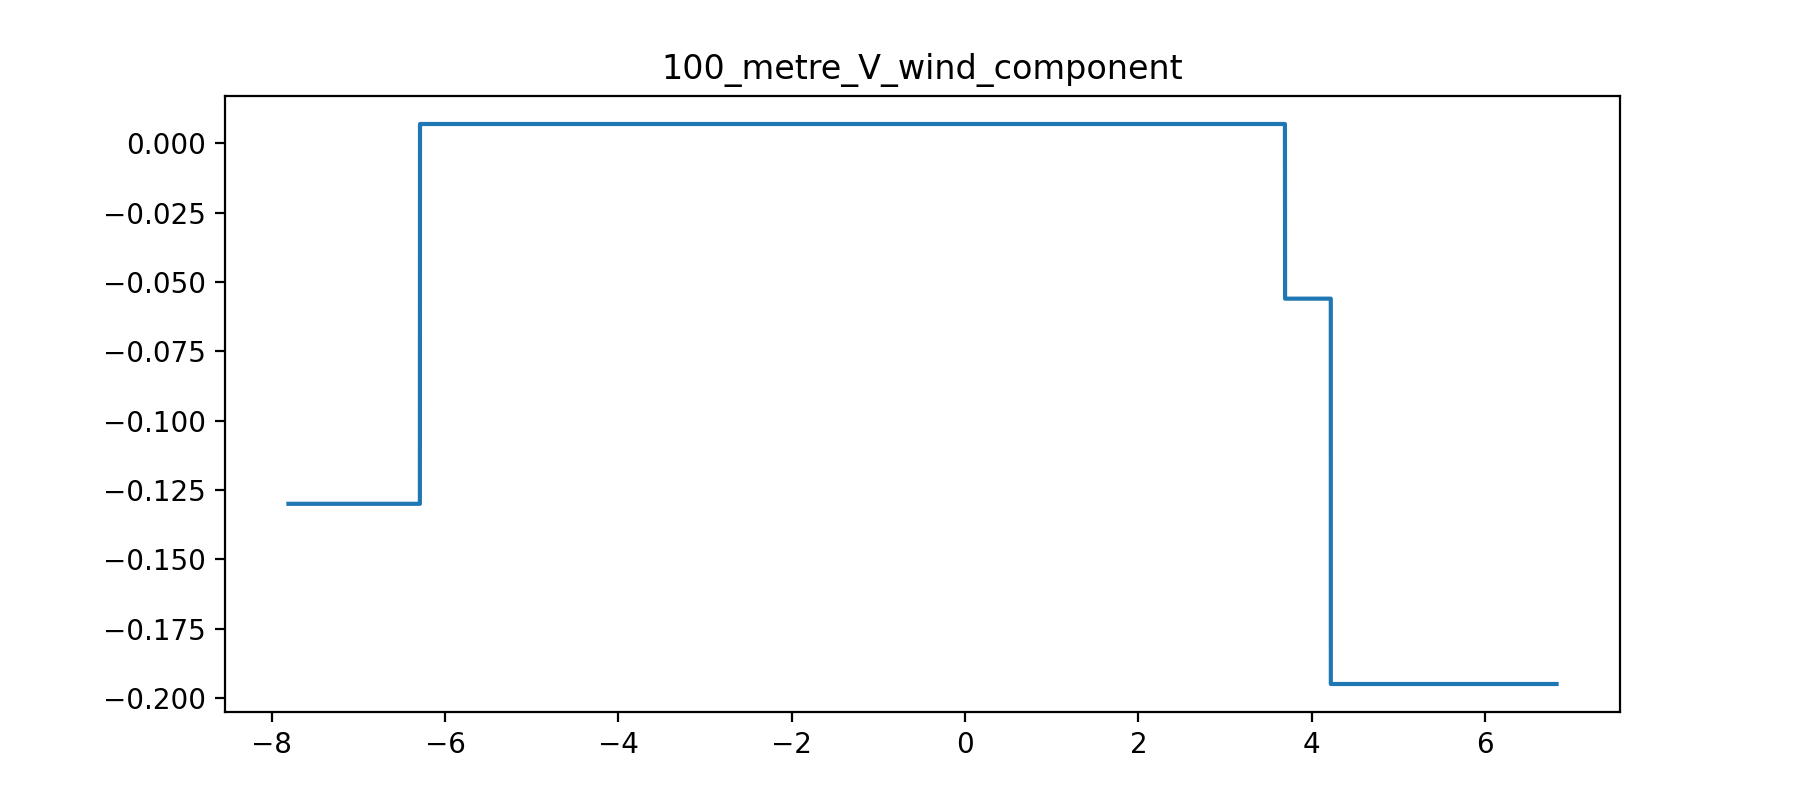

In [12]:
dffea = feature_en2.transform(dftt.rolling(96).mean())
dffea2 = dffea.copy()
Y_ori = dffea['load'].copy()
dffea2 = dffea.copy()
dffea2['load'] = (dffea2['load'] - dffea2['load'].shift(192)) #.iloc[192:]
Y = dffea2.pop('load')
X = dffea2

split1 = datetime(2022,5,1,0,15)
split2 = datetime(2022,6,1,0,15)

if xslice == 'summer':
    slice0 = slice(datetime(2020,6,1), datetime(2020,9,1))
    slice1 = slice(datetime(2021,6,1), datetime(2021,9,1))
    slice2 = slice(datetime(2022,5,1), datetime(2022,6,1))
    X_train = pd.concat([X[slice0], X[slice1], X[slice2]])
    Y_train = pd.concat([Y[slice0], Y[slice1], Y[slice2]])
elif xslice == 'all':
    split0 = datetime(2020,7,1,0,15)
    X_train = X[split0:split1]
    Y_train = Y[split0:split1]  
pool = Pool(X_train,Y_train,feature_names=list(dffea2.columns))
result_dict = extract_basis_from_catboost(model,pool,dffea2)
for key,val in result_dict.items():
#     if 'Surface_net_solar_radiation' not in key:
#         continue
#     if 'load' in key:
#         continue
#     if 'temperature' in key:
#         continue
    if key not in ['Surface_pressure','Total_cloud_cover','Surface_net_solar_radiation','Total_precipitation',
                   'Skin_temperature','100_metre_U_wind_component','100_metre_V_wind_component']:
#     if key != 'Total_precipitation':
        continue
    plt.figure(figsize=(9,4))
    plt.plot(val['index'],val['value'])
    plt.show()
    plt.title(key)
    plt.savefig("jiangxi_"+key+".png")

In [11]:
list(dft.columns)

['Unnamed_0',
 'Surface_pressure',
 'Surface_sensible_heat_flux',
 'Total_cloud_cover',
 '10_metre_U_wind_component',
 '10_metre_V_wind_component',
 '2_metre_temperature',
 '2_metre_dewpoint_temperature',
 'Surface_solar_radiation_downwards',
 'Surface_net_solar_radiation',
 'Surface_net_solar_radiation_clear_sky',
 'Total_precipitation',
 'Skin_temperature',
 '100_metre_U_wind_component',
 '100_metre_V_wind_component',
 'load']